In [21]:
from odes.models import SIR
from odes.integrator import integrator
from odes.neural_ODE import nUIV_NODE
import torch
# import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

In [22]:
# helper function to step the SIR model forward and generate a data set
def generate_SIR_data(model, num_steps):
    t = torch.zeros(num_steps)
    y = torch.zeros(3, num_steps)
    y[:, 0] = torch.from_numpy(model.x)
    t[0] = torch.tensor(0.0)
    for i in range(num_steps):
        y[:, i] = torch.from_numpy(model.step())
        t[i] = torch.tensor(model.t)
    return y, t


def lp_norm_loss(y, yhat, p=2):
    return torch.norm(y-yhat, p=p)

In [23]:
# setting up SIR reference data
num_hosts = 50
num_steps = 400
dt = 0.05
torch.manual_seed(666)

time_scale = 25.0  # can make time "move faster" by scaling these constants beyond [0, 1]
beta = time_scale*0.9  # infection rate
gamma = time_scale*0.01  # recovery rate
SIR_ODE = SIR(num_hosts, beta, gamma)
SIR_x0 = np.array([0.75, 0.25, 0.0])


# generate data
SIR_stepper = integrator(SIR_ODE, SIR_x0, dt)
SIR_train_data, time_train_data = generate_SIR_data(SIR_stepper, num_steps)

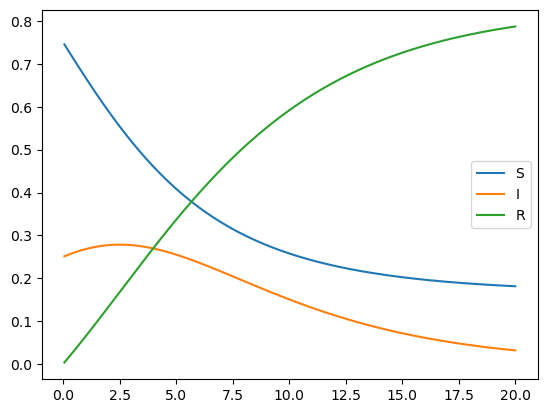

In [24]:
plt.plot(time_train_data, SIR_train_data.T)
plt.legend(["S","I","R"])
plt.show()

In [25]:
# build model and fit it
method = 'euler'
step_size = 2*dt
# build model and fit it
device = 'cpu'  # torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = nUIV_NODE(num_hosts, method=method, step_size=step_size).to(device)
num_epochs = 200
optimizer = optim.Adam(model.parameters(), lr=1e-1, weight_decay=0.0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, verbose=True)
loss_function = lambda y, yhat: lp_norm_loss(y, yhat, p=2)  # nn.L1Loss()

In [26]:
train_beta = torch.tensor([1.35e-7,1.26e-7,5.24e-7,7.92e-10,1.51e-7,5.74e-10,1.23e-7,2.62e-9,3.08e-10])
log_train_beta = torch.log10(train_beta)
train_delta = torch.tensor([0.61,0.81,0.51,1.21,2.01,0.81,0.91,1.61,2.01])
#train_p = torch.tensor([0.2,0.2,0.2,361.6,0.2,382,0.2,278.2,299])
#log_train_p = torch.log10(train_p)
train_p = torch.tensor([0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2])
train_c = 2.4*torch.ones(9)

#train_params = torch.tensor([torch.mean(log_train_beta),torch.mean(train_delta),torch.mean(log_train_p),torch.mean(train_c)])
train_params = torch.cat((torch.mean(log_train_beta)*torch.ones(num_hosts),torch.mean(train_delta)*torch.ones(num_hosts),torch.mean(train_p)*torch.ones(num_hosts),torch.mean(train_c)*torch.ones(num_hosts)))

com_train = torch.cat((SIR_train_data[1,:],0.01*train_params,torch.zeros(num_hosts)))

In [27]:
for epoch in range(num_epochs):
    optimizer.zero_grad()
    SIR_est = model.simulate(time_train_data.to(device)).to(device)
    UIV_x0_est = model.nUIV_x0
    #UIV_x0_est = UIV_x0_est.T
    #UIV_U0_est = UIV_x0_est[::3]
    #UIV_I0_est = UIV_x0_est[1::3]
    #UIV_V0_est = UIV_x0_est[2::3]
    #com_est = torch.cat((SIR_est[1,:],1/5*torch.log10(UIV_U0_est),1/5*UIV_I0_est,1/5*torch.log10(UIV_V0_est)),dim=0)

    beta_est = model.nUIV_dynamics.betas
    log_beta_est = torch.log10(beta_est)
    delta_est = model.nUIV_dynamics.deltas
    p_est = model.nUIV_dynamics.ps
    log_p_est = torch.log10(p_est)
    c_est = model.nUIV_dynamics.cs

    #params_est = torch.tensor([torch.mean(log_beta_est),torch.mean(delta_est),torch.mean(log_p_est),torch.mean(c_est)])
    params_est = torch.cat((log_beta_est,delta_est,p_est,c_est))

    com_est = torch.cat((SIR_est[1,:],0.01*params_est,UIV_x0_est[3::4]))

    loss = loss_function(com_est, com_train.to(device))
    #loss = loss_function(SIR_est, SIR_train_data.to(device))
    loss_val = loss.item()
    loss.backward()
    optimizer.step()
    scheduler.step(loss_val)

    print(f'Epoch {epoch}, loss value: {loss_val}.')
    if torch.isnan(loss):
        raise ValueError('Found NaN loss, exiting...')

Epoch 0, loss value: 13.923954963684082.


In [28]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter name: {name}, Gradient: {param.grad}")


nUIV_params = model.get_params()
SIR_params = {'beta': beta,
              'gamma': gamma,
              'x0': SIR_x0,
              'num_hosts': num_hosts}

sim_params = {'SIR': SIR_params,
              'nUIV': nUIV_params}

print(nUIV_params)

Parameter name: nUIV_dynamics.parametrizations.betas.original, Gradient: tensor([ 1.6799e-01, -3.7602e-04,  2.0197e-01,  4.3558e-02, -7.7081e-03,
         2.2028e-02, -1.2348e-02, -6.7431e-04, -3.0143e-03,  5.0622e-04,
         5.5154e-01,  5.6770e-04,  7.7330e-02, -1.2486e-02,  3.4515e-02,
        -2.7407e-03, -1.1109e-02, -2.7023e-02,  1.3317e-01,  9.4141e-03,
         2.2887e-03, -3.7328e-03,  5.2424e-02,  1.2181e-01, -1.1012e-03,
         2.4020e-02, -2.5837e-02,  1.7934e-02, -5.6694e-03,  4.7878e-02,
         9.0415e-03,  3.0957e-05,  3.7201e-02,  6.7985e-03,  9.9475e-02,
         1.4039e-02, -1.5254e-02,  1.7806e-04, -4.6569e-03,  1.0998e-02,
        -5.3470e-03,  2.1757e-01, -1.5898e-02,  7.0713e-03,  3.0011e-05,
         7.7018e-02, -5.8309e-03, -1.0760e-02, -2.6368e-02,  1.5831e-02])
Parameter name: nUIV_dynamics.parametrizations.deltas.original, Gradient: tensor([-2.3706e-01, -4.2359e-03, -1.6776e-01, -5.4371e-02, -1.7840e-01,
        -1.1253e-01, -1.9419e-01, -2.9001e-02, -4

Resetting to stored initial state.
Resetting to t=0.0.


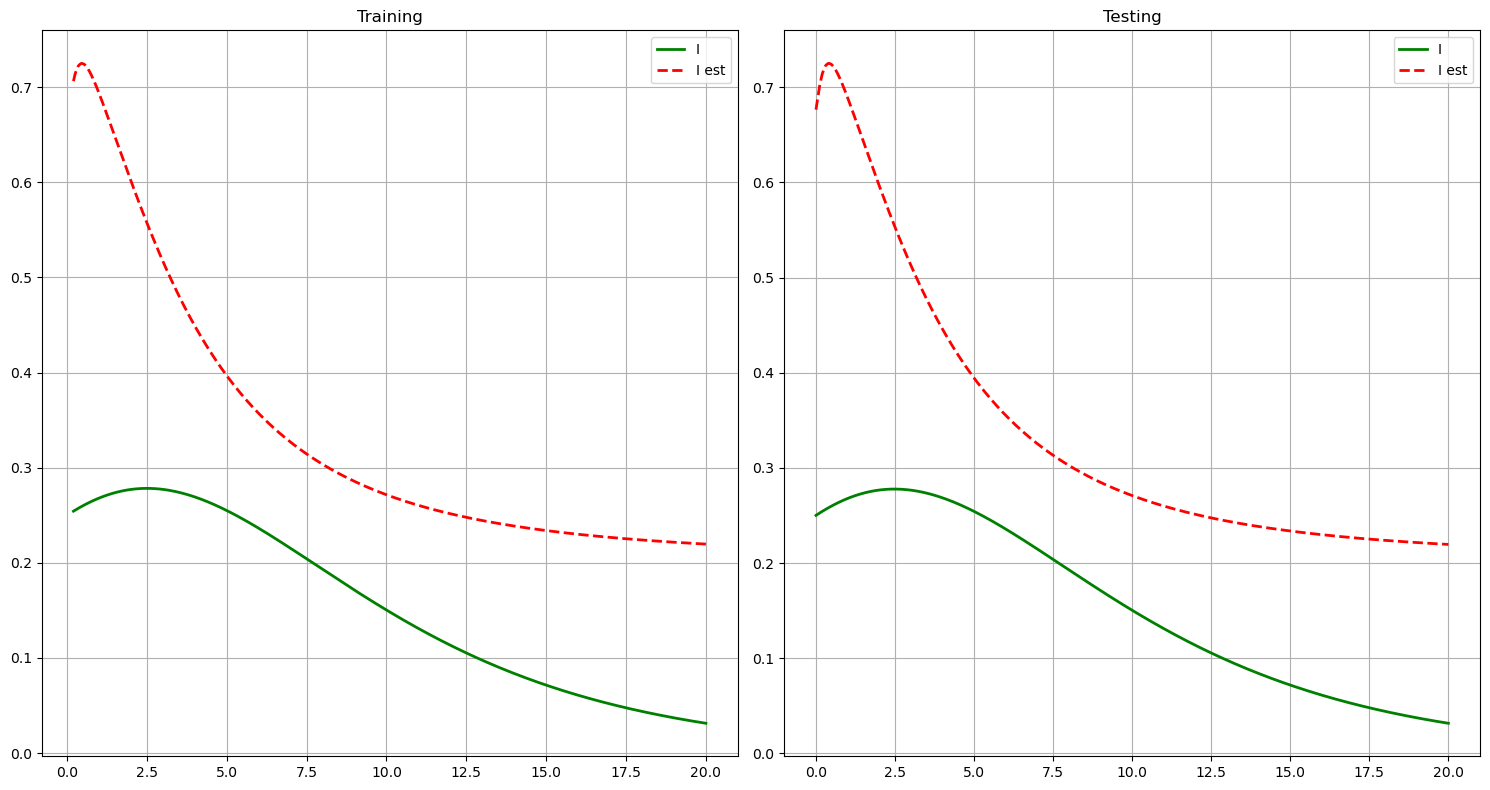

[0.67575955 0.6759815  0.67620355 0.6764259  0.67664826 0.6768709
 0.6770937  0.6773166  0.67753977 0.677763  ]
[0.67575955 0.6870171  0.6983174  0.70638394 0.7138268  0.7184497
 0.7223012  0.72403747 0.72509456 0.7246927 ]


In [29]:
# TODO: Write testing block to visualize the quality of the fit ODE
# First, reset the SIR model, change its time step
SIR_stepper.reset()
SIR_stepper.dt = 0.001
num_steps = 20000
SIR_test_data, time_test_data = generate_SIR_data(SIR_stepper, num_steps)

with torch.no_grad():
    SIR_train_data_est = model.simulate(time_train_data.to(device)).detach().cpu().numpy()
    SIR_test_data_est = model.simulate(time_test_data.to(device)).detach().cpu().numpy()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
names = ['S', 'I', 'R']
colors = ['red', 'green', 'blue']
'''
for i, name in enumerate(names):
    ax1.plot(time_train_data, SIR_train_data[i, :], lw=2, color=colors[i], label=name)
    ax1.plot(time_train_data, SIR_train_data_est[i, :], lw=2, color=colors[i], label=name+' est', linestyle='dashed')
    ax2.plot(time_test_data, SIR_test_data[i, :], lw=2, color=colors[i], label=name)
    ax2.plot(time_test_data, SIR_test_data_est[i, :], lw=2, color=colors[i], label=name+' est', linestyle='dashed')
'''
# np.save("train_time.np", time_train_data)
# np.save("test_time.np", time_test_data)
# np.save("train_est.np", SIR_train_data_est)
# np.save("test_est.np", SIR_test_data_est)
ax1.plot(time_train_data[3:], SIR_train_data[1, 3:], lw=2, color=colors[1], label=names[1])
ax1.plot(time_train_data[3:], SIR_train_data_est[1, 3:], lw=2, color=colors[0], label=names[1]+' est', linestyle='dashed')
ax2.plot(time_test_data[3:], SIR_test_data[1, 3:], lw=2, color=colors[1], label=names[1])
ax2.plot(time_test_data[3:], SIR_test_data_est[1, 3:], lw=2, color=colors[0], label=names[1]+' est', linestyle='dashed')
ax1.set_title('Training')
ax2.set_title('Testing')
ax1.grid()
ax2.grid()
ax1.legend()
ax2.legend()
f.tight_layout()
path = './tmp/'
# path = '/content/tmp/'
if not os.path.exists(path):
    os.mkdir(path)
filename = os.path.join(path, 'last_run_pytorch.png')
f.savefig(filename)
plt.show()

print(SIR_test_data_est[1, :10])
print(SIR_train_data_est[1, :10])

In [30]:
model.nUIV_x0[3::4].data = torch.zeros_like(model.nUIV_x0[3::4].data)
model.nUIV_x0[3::4]

tensor([4.7570e-02, 3.6441e-02, 4.1321e-01, 7.9123e-01, 5.8736e-01, 7.2821e-01,
        3.0785e-05, 2.1086e-02, 4.6541e-01, 4.2280e-03, 6.3050e-03, 3.8372e-01,
        1.5316e-01, 7.0286e-02, 5.4433e-01, 7.0383e-01, 7.5425e-01, 3.3194e-01,
        1.6554e-02, 4.3187e-01, 6.8632e-01, 4.2456e-01, 1.4145e-01, 5.0207e-02,
        6.2285e-02, 6.1513e-01, 6.1744e-01, 7.1470e-02, 7.2019e-01, 3.0020e-02,
        7.2049e-02, 3.0825e-01, 2.1578e-01, 5.3544e-01, 4.4767e-01, 4.1794e-01,
        8.0663e-01, 3.6645e-01, 3.2150e-01, 1.7500e-02, 1.1260e-01, 1.4124e-01,
        1.3021e-01, 4.4842e-01, 6.6982e-01, 4.5949e-01, 5.0361e-01, 6.5428e-01,
        1.0922e-01, 4.4075e-01], grad_fn=<SliceBackward0>)